In [112]:
import nltk
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Dense,LSTM,Dropout,Input,Activation,Embedding,GlobalMaxPool1D,GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential, Model
from sklearn.metrics import roc_auc_score

In [80]:
# Loading the train data
raw_train_data = pd.read_csv("train.csv")

In [81]:
raw_test_data = pd.read_csv("test.csv")

In [82]:
# Printing the first 5 records to take a glance at the data we have
raw_train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [83]:
# Printing the first 5 records to take a glance at the data we have
raw_test_data.head()

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,5,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
1,7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
2,11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
3,13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
4,14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0


In [84]:
# Getting rid of the id column as its completely irrelevant
rel_data = raw_train_data.drop("id",axis=1)
rel_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [85]:
# Getting rid of the unnamed and id column from the test dataset
cols_to_remove = raw_test_data.columns[:2]
test_data = raw_test_data.drop(cols_to_remove,axis=1)
test_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Thank you for understanding. I think very high...,0,0,0,0,0,0
1,:Dear god this site is horrible.,0,0,0,0,0,0
2,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
3,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
4,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0


In [86]:
# Now deleting records with empty string values in the comment_text column of train dataset
rel_data = rel_data.where(rel_data['comment_text'] !="")

In [87]:
# Now deleting records with empty string values in the comment_text field of the test dataset
test_data = test_data.where(test_data['comment_text'] !="")

In [88]:
# Getting rid of escape characters in train data
rel_data['comment_text'] = rel_data.apply(lambda x: re.sub("[\n\t\b]"," ",x['comment_text']),axis=1)

In [89]:
# Getting rid of escape characters in test data
test_data['comment_text'] = test_data.apply(lambda x: re.sub("[\n\t\b]"," ",x['comment_text']),axis=1)

In [90]:
# Getting rid of punctuation marks in train data
rel_data['comment_text'] = rel_data.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation)," ",x['comment_text']),axis=1)

In [91]:
# Getting rid of punctuation marks in test data
test_data['comment_text'] = test_data.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation)," ",x['comment_text']),axis=1)

In [92]:
# Converting everything to lowercase in train data
rel_data['comment_text'] = rel_data.apply(lambda x: x['comment_text'].lower(),axis=1)

In [93]:
# Converting everything to lowercase in test data
test_data['comment_text'] = test_data.apply(lambda x: x['comment_text'].lower(),axis=1)

In [94]:
# Preparing data for plotting class distribution in training dataset
class_counts = []
for col in rel_data.columns[1:]:
    class_counts.append((rel_data[col]!=0).sum())

Text(0, 0.5, 'Number of Records')

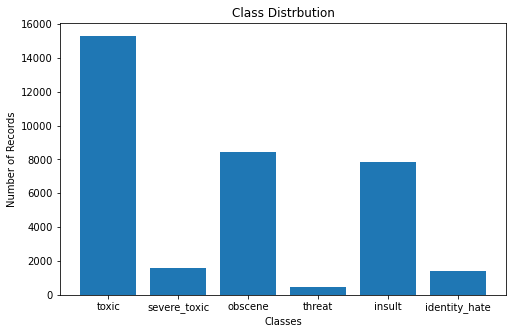

In [95]:
# Plotting the Class Distribution
plt.figure(figsize=(8,5))
plt.bar(rel_data.columns[1:],class_counts)
plt.title("Class Distrbution")
plt.xlabel("Classes")
plt.ylabel("Number of Records")

In [96]:
# Tokenizing the comments_text in training dataset
rel_data['comments_tokenized'] = rel_data.apply(lambda x: nltk.tokenize.word_tokenize(x['comment_text']),axis=1)

In [97]:
# Tokenizing the comments_text in test dataset
test_data['comments_tokenized'] = test_data.apply(lambda x: nltk.tokenize.word_tokenize(x['comment_text']),axis=1)

In [98]:
# Removing the stopwords from the tokenized data in the training dataset
stopwords = nltk.corpus.stopwords.words("english")
rel_data['comments_nostop'] = rel_data.apply(lambda x: [word for word in x['comments_tokenized'] if word not in stopwords],axis=1)

In [99]:
# Removing the stopwords from the tokenized data in the test dataset
stopwords = nltk.corpus.stopwords.words("english")
test_data['comments_nostop'] = test_data.apply(lambda x: [word for word in x['comments_tokenized'] if word not in stopwords],axis=1)

In [100]:
# Printing top 5 records of training dataset to see the outcome of the pre-processing we did so far
rel_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comments_tokenized,comments_nostop
0,explanation why the edits made under my userna...,0,0,0,0,0,0,"[explanation, why, the, edits, made, under, my...","[explanation, edits, made, username, hardcore,..."
1,d aww he matches this background colour i m s...,0,0,0,0,0,0,"[d, aww, he, matches, this, background, colour...","[aww, matches, background, colour, seemingly, ..."
2,hey man i m really not trying to edit war it...,0,0,0,0,0,0,"[hey, man, i, m, really, not, trying, to, edit...","[hey, man, really, trying, edit, war, guy, con..."
3,more i can t make any real suggestions on im...,0,0,0,0,0,0,"[more, i, can, t, make, any, real, suggestions...","[make, real, suggestions, improvement, wondere..."
4,you sir are my hero any chance you remember...,0,0,0,0,0,0,"[you, sir, are, my, hero, any, chance, you, re...","[sir, hero, chance, remember, page]"


In [101]:
# Printing top 5 records of test dataset to see the outcome of the pre-processing we did so far
test_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comments_tokenized,comments_nostop
0,thank you for understanding i think very high...,0,0,0,0,0,0,"[thank, you, for, understanding, i, think, ver...","[thank, understanding, think, highly, would, r..."
1,dear god this site is horrible,0,0,0,0,0,0,"[dear, god, this, site, is, horrible]","[dear, god, site, horrible]"
2,somebody will invariably try to add relig...,0,0,0,0,0,0,"[somebody, will, invariably, try, to, add, rel...","[somebody, invariably, try, add, religion, rea..."
3,it says it right there that it is a type ...,0,0,0,0,0,0,"[it, says, it, right, there, that, it, is, a, ...","[says, right, type, type, institution, needed,..."
4,before adding a new product to the lis...,0,0,0,0,0,0,"[before, adding, a, new, product, to, the, lis...","[adding, new, product, list, make, sure, relev..."


In [102]:
# Creating a tokenizer object which will help us in tokenizing comments_nostop
max_features = 20000
tokenizer = tf.keras.preprocessing.text.Tokenizer(max_features)

In [103]:
# Fitting the tokenizer on our training dataset
tokenizer.fit_on_texts(rel_data['comments_nostop'])

In [104]:
tokenized_train = tokenizer.texts_to_sequences(rel_data['comments_nostop'])

In [105]:
tokenized_train[5]

[2526, 25, 16, 2079, 25, 891, 4]

In [106]:
tokenized_test = tokenizer.texts_to_sequences(test_data['comments_nostop'])

In [107]:
tokenized_test[12]

[627, 1220, 22, 845, 284, 10208, 627, 2730, 627, 2682, 25, 69, 703, 9231]

In [108]:
# Finding out the length of each cleaned comment
rel_data['clean_comment_len'] = rel_data.apply(lambda x: len(x['comments_nostop']),axis=1)

In [109]:
rel_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comments_tokenized,comments_nostop,clean_comment_len
0,explanation why the edits made under my userna...,0,0,0,0,0,0,"[explanation, why, the, edits, made, under, my...","[explanation, edits, made, username, hardcore,...",27
1,d aww he matches this background colour i m s...,0,0,0,0,0,0,"[d, aww, he, matches, this, background, colour...","[aww, matches, background, colour, seemingly, ...",14
2,hey man i m really not trying to edit war it...,0,0,0,0,0,0,"[hey, man, i, m, really, not, trying, to, edit...","[hey, man, really, trying, edit, war, guy, con...",21
3,more i can t make any real suggestions on im...,0,0,0,0,0,0,"[more, i, can, t, make, any, real, suggestions...","[make, real, suggestions, improvement, wondere...",52
4,you sir are my hero any chance you remember...,0,0,0,0,0,0,"[you, sir, are, my, hero, any, chance, you, re...","[sir, hero, chance, remember, page]",5


In [110]:
# Finding the maximum length of the cleaned comments.
max_len = rel_data['clean_comment_len'].max()
max_len

1250

Text(0, 0.5, 'Number of Comments')

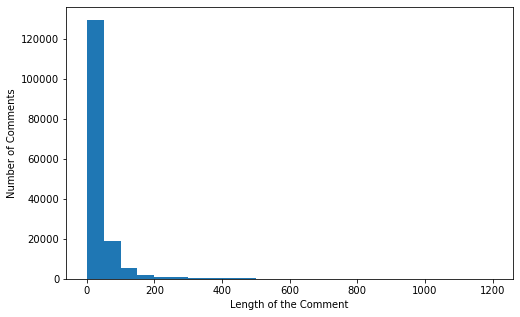

In [115]:
# Plotting a histogram to identify the comment length distribution
plt.figure(figsize=(8,5))
plt.hist(rel_data['clean_comment_len'],bins=np.arange(0,max_len,50))
plt.xlabel("Length of the Comment")
plt.ylabel("Number of Comments")

In [22]:
# Setting the maximum length for the sequence we are going to feed to the LSTM
maxSeqLen = 200

In [23]:
# Padding all the sequences in the train dataset to make all the comments of length maxSeqLen
train = tf.keras.preprocessing.sequence.pad_sequences(tokenized_train,maxlen=maxSeqLen)

In [58]:
# Padding all the sequences in the test dataset to make all the comments of the predefined standard length
test = tf.keras.preprocessing.sequence.pad_sequences(tokenized_test,maxlen=maxSeqLen)

In [24]:
# We have a training dataset with N records each of which contains exactly 200 tokens
train.shape

(159571, 200)

In [59]:
test.shape

(63978, 200)

In [25]:
# Creating target lables for training dataset
target_cols = raw_data.columns[2:]
y = rel_data[target_cols].values
y.shape

(159571, 6)

In [61]:
# Creating target lables for test dataset
y_test = test_data[target_cols].values
y_test.shape

(63978, 6)

In [26]:
# Creating LSTM Model
inp = Input(shape=(maxSeqLen,))
x = Embedding(max_features,128)(inp)
x = LSTM(60,return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50,activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6,activation="sigmoid")(x)
model = Model(inputs=inp,outputs=x)

In [27]:
# Printing model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 128)          2560000   
_________________________________________________________________
lstm (LSTM)                  (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0     

In [28]:
# Compiling the model with default values of the Adam optimizer
model.compile(Adam(),loss="binary_crossentropy",metrics=["accuracy"])

In [29]:
# Defining some hyperparameters
batch_size = 32
epochs = 5

In [30]:
# Calling the .fit() method to begin the training
model.fit(train,y,batch_size,epochs,validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/5
143613/143613 [==============================] - 861s 6ms/sample - loss: 0.0737 - accuracy: 0.9763 - val_loss: 0.0512 - val_accuracy: 0.9810
Epoch 2/5
143613/143613 [==============================] - 826s 6ms/sample - loss: 0.0451 - accuracy: 0.9830 - val_loss: 0.0482 - val_accuracy: 0.9816
Epoch 3/5
143613/143613 [==============================] - 819s 6ms/sample - loss: 0.0388 - accuracy: 0.9848 - val_loss: 0.0482 - val_accuracy: 0.9823
Epoch 4/5
143613/143613 [==============================] - 828s 6ms/sample - loss: 0.0336 - accuracy: 0.9867 - val_loss: 0.0517 - val_accuracy: 0.9815
Epoch 5/5
143613/143613 [==============================] - 841s 6ms/sample - loss: 0.0294 - accuracy: 0.9883 - val_loss: 0.0566 - val_accuracy: 0.9807


In [65]:
loss, accuracy = model.evaluate(test,y_test)

63978/63978 [==============================] - 90s 1ms/sample - loss: 0.0808 - accuracy: 0.9679


In [76]:
print("Your model attained an accuracy of {}% and a loss of {} on the test dataset".format(round(accuracy*100,2),round(loss,5)))

Your model attained an accuracy of 96.79% and a loss of 0.08082 on the test dataset


In [113]:
pred = model.predict(test)
roc_auc_score(y_test,pred)

0.9716722086571492